In [2]:
import pandas as pd
import numpy as np
import fiona
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

%matplotlib inline

/Users/shruti/.virtualenvs/playground/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
with fiona.open('data/zonal_stats/ClimateZones/CA_Building_Standards_Climate_Zones_epsg4326.shp') as shapefile:
    features = [feature["geometry"] for feature in shapefile]
features[1]

DriverError: data/zonal_stats/ClimateZones/CA_Building_Standards_Climate_Zones_epsg4326.shp: No such file or directory

### Convert NetCDF file to multiband GeoTIFF

In [46]:
crs = 'EPSG:4326'

with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041.nc') as src:
    transform, width, height = calculate_default_transform(
        crs, crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': crs,
        'transform': transform,
        'width': width,
        'height': height,
        'driver': 'GTiff',
    })
    # Reproject to geotiff
    with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041_wgs84.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=src.crs,
                resampling=Resampling.nearest)

(-118.46875, 38.15625)


### Clip GeoTIFF file with polygon

In [77]:
with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041_wgs84.tif') as src:
    # Clip
    out_image, out_transform = rasterio.mask.mask(src, [features[3]], crop=True, nodata=src.nodata)
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                 'height': out_image.shape[1],
                 'width': out_image.shape[2],
                 'transform': out_transform})
    with rasterio.open('data/zonal_stats/clip_wgs84.tif', 'w', **out_meta) as dest:
        dest.write(out_image)

270.9554 281.89972 277.33174261083747


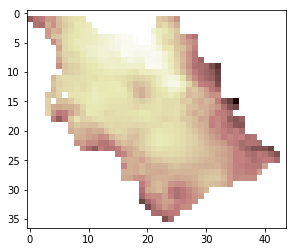

In [90]:
with rasterio.open('data/zonal_stats/clip_wgs84.tif') as src:
    arr = src.read(1, masked=True)
    print(arr.min(), arr.max(), arr.mean())
    plt.imshow(arr, cmap='pink')
    plt.show()  

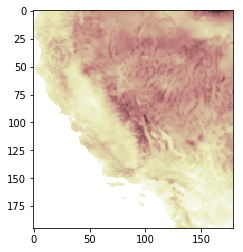

In [103]:
with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041.nc') as src:
    arr = src.read(1, masked=True)
    plt.imshow(arr, cmap='pink')
    plt.show()  